1. Install all the packages needed for both using a LangChain on Vertex AI agent as well as creating one

In [ ]:
!pip install --upgrade google-cloud-aiplatform
!pip install --upgrade google-cloud-bigquery
!pip install --upgrade --quiet \
    langchain==0.1.20 \
    langchain-google-vertexai==1.0.3 \
    cloudpickle==3.0.0 \
    pydantic==2.7.1 \
    langchain_google_community \
    google-cloud-discoveryengine \
    google-api-python-client \
    requests \
    ratelimiter \
    python-dotenv

2. Import the required packages

In [ ]:
import base64
import vertexai
from vertexai.generative_models import GenerativeModel, Part, FinishReason
import vertexai.preview.generative_models as generative_models
from google.cloud import bigquery

from google.api_core.client_options import ClientOptions
#from google.cloud import discoveryengine_v1 as discoveryengine
#from dotenv import load_dotenv, find_dotenv
from vertexai.preview import reasoning_engines
from googleapiclient import discovery
from langchain.agents.format_scratchpad import format_to_openai_function_messages
from langchain.memory import ChatMessageHistory
from operator import itemgetter
from typing import List
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.documents import Document
from langchain_core.messages import BaseMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import (
    RunnableLambda,
    ConfigurableFieldSpec,
    RunnablePassthrough,
)
from langchain_google_vertexai import HarmBlockThreshold, HarmCategory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core import prompts
from langchain_core import agents
from langchain.agents.format_scratchpad import (
    format_to_openai_function_messages
)

import google.auth
import json
import os
import requests




3. Global variables needed and obtaining principal's token.  You have to replace the variable values with your values.

In [ ]:
PROJECT_ID="enterprise-search-gen-ai"
LOCATION="global"
STAGING_BUCKET="gs://agent-test-srini"
credentials, _ = google.auth.default()
request = google.auth.transport.requests.Request()
credentials.refresh(request)

4. Initiatilize Vertex AI

In [ ]:
vertexai.init(project="enterprise-search-gen-ai", location="us-central1", staging_bucket=STAGING_BUCKET)

5. Here is the code to implementa natural language to SQL translation using Gemini as the LLM and BigQuery as the database using the architecture below [NOTE:  This solution is meant to serve just as a quick example.  Use other more robust tools for more generic solutions. 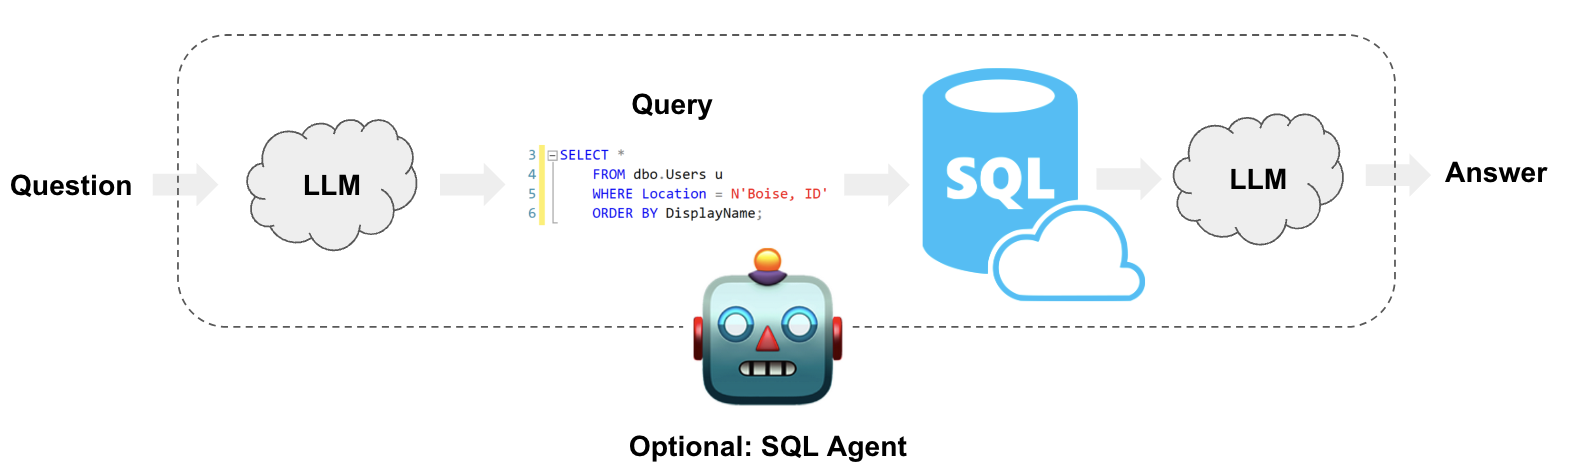

In [ ]:
#LLM settings
generation_config = {
    "max_output_tokens": 8192,
    "temperature": 1,
    "top_p": 0.95,
}

safety_settings = {
    generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
}

#Gemini generates SQL based on the information about the table provided in the preamble to the prompt
def generate_sql(nl_query):
  prompt_preamble = """There is a table by name \'enterprise-search-gen-ai.incidentsDS.incidents\'.  It has these fields with the (data type):

  incident (interger)
  outage_duration_hours (float)
  cause_identification_attempts (integer)

  Generate a SQL query to answer this question.  Provide only the SQL that can be executed and do not include any explanation:
  """
  model = GenerativeModel(
    "gemini-1.5-pro-001",
  )
  #print(nl_query)
  responses = model.generate_content(
      prompt_preamble + nl_query,
      generation_config=generation_config,
      safety_settings=safety_settings,
      stream=True,
  )
  return_value = ''
  for response in responses:
    return_value = return_value + response.text.lstrip('sql')
  #print (return_value)
  return return_value

#Use the query generated by Gemini to query BigQuery
def query_bq(query):
  client = bigquery.Client()
  rows = query_job = client.query_and_wait(query)  # Make an API request.
  for row in rows:
    return row[0]

#Generate a natural language response from the original natural language query and the BigQuery return value
def generate_response(nl_query, sql_response):
  prompt_preamble = f"""From the user\'s question and the answer below, generate a professional response.  Round floats to integers.  The durations are in hours.  Convert durations shorter than one hour to minutes:

    User\'s question: {nl_query}
    Answer: {sql_response}"""
  model = GenerativeModel(
    "gemini-1.5-pro-001",
  )
  responses = model.generate_content(
      prompt_preamble + nl_query,
      generation_config=generation_config,
      safety_settings=safety_settings,
      stream=True,
  )
  return_value = ''
  for response in responses:
    return_value = return_value + response.text.lstrip('sql')
  return return_value

#The primary function that calls the three functions above.  This is  the function called by the Reasoning Engine
#The comments immediately after the function definition are used the Reasoning Engine in its orchestration
def answer_from_db(nl_query: str):
  """Call this function to answer only statistical questions about past incidents,their outage duration, and the number of cause identification attempts.
  Example questions this function must be called for:
  - Find the percentage of incidents that required more than one cause identification attempt
  - Find the longest outage duration
  - Find the average outage duration of all the insidents
  - Find the average number of cause identification attempts
  It takes a string as a query and returns a string that has the information on incidents"""
  sql_query = generate_sql(nl_query)
  #print(sql_query)
  #print(sql_query.replace("```", "").replace('FLOAT', 'FLOAT64'))
  sql_response = query_bq(sql_query.replace("```", "").replace('FLOAT', 'FLOAT64'))
  return generate_response(nl_query, sql_response)

print(answer_from_db('Find the percentage of incidents that required more than one cause identification attempt'))
#print(answer_from_db('Find the longest outage duration'))
#print(answer_from_db('Find the average outage duration of all the insidents'))
#print(answer_from_db('Find the average number of cause identification attempts'))




Approximately 45% of incidents required more than one attempt to identify the cause. 



6. A function to call

In [ ]:
def make_curl_call_to_agent(query_str: str):
  """Call this function to answer any question about information in TM Forum assets and to generate code.
  Example questions this function must be called for:
  - Describe ODF
  - List the eTOM processes TMFC001 is responsible for
  - How do I start building an autonomous network?
  - Is ODA AI ready?
  - Generate code in java for product catalogue
  - Generate code in python for Trouble ticket API
  - generate  code for  TMF637
  """
  import json
  # Get the access token from Google Cloud SDK
  credentials, _ = google.auth.default()
  credentials.refresh(request)
  token = credentials.token

  # Set the headers and data
  headers = {
    "Authorization": f"Bearer {token}",
    "Content-Type": "application/json; charset=utf-8",
  }

  # Create the JSON payload from the query_str
  json_input = {"input": {"input": f"{query_str}"}}


  # Construct the URL
  url = "https://us-central1-aiplatform.googleapis.com/v1beta1/projects/982845833565/locations/us-central1/reasoningEngines/3098793202979700736:query"

  # Send the POST request
  r = requests.post(url, headers=headers, data=json.dumps(json_input))
  #pprint.pprint(response)
  return r.json()

In [ ]:
import pprint
#res = make_curl_call_to_agent("What is intent in Autonomous networks?")
#res = make_curl_call_to_agent("Generate Java code for Product Inventory Management")
#res = make_curl_call_to_agent("Describe ODF")
#print(res['output']['intermediate_steps'][0][1][0]['answer']['references'][0]['chunkInfo']['documentMetadata']['title'])
#print(res)
pprint.pprint(res['output']['output'])
#print(res['output']['intermediate_steps'][0][1][0]['answer']['answerText'])
#print(res['output']['intermediate_steps'][0][1][1]['answer']['answerText'])
#print(res['output']['intermediate_steps'][0][1][2]['results'][0]['document']['derivedStructData']['image']['contextLink'])
#print(res['output']['intermediate_steps'][0][1][2])
#pprint.pprint(res['output']['intermediate_steps'])
#print (len(res['output']['intermediate_steps'][0][1]))
#print(res['output']['intermediate_steps'][0][1][2])
#print(res['output']['intermediate_steps'])
#print(res['output']['output'])
#print(res['output']['intermediate_steps'][0][1][0])

('The Java code for Product Inventory Management is generated and can be '
 'downloaded from this URL: '
 'https://storage.cloud.google.com/tfm-ai-assistant-codegen-dev/generatedCodeFile/TMF637-ProductInventory-v5_1717714196566.zip \n')


In [ ]:
AGENT_LLM_MODEL = "gemini-1.5-pro"
agent = reasoning_engines.LangchainAgent(
    model=AGENT_LLM_MODEL,
    tools=[make_curl_call_to_agent, answer_from_db],
    agent_executor_kwargs={"return_intermediate_steps": True},
)

In [ ]:
res = agent.query(input="What is the Industry response to GenAI and use of LLMs in terms of risk?")
#res = agent.query(input="Generate Ruby code for  Service Inventory Managenement")
#res = agent.query(input='Find the average number of cause identification attempts')

print (res["output"])
print(res['intermediate_steps']['intermediate_steps'][0][1][2])
#print (res)